In [1]:
!pip install opendatasets

In [2]:
# Import libraries
import pandas as pd
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import glob
import os
import pathlib
import PIL
from PIL import Image
import PIL.Image
import PIL.ImageShow
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers.legacy import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import Sequential
from tensorflow.compat.v1.keras.layers import BatchNormalization
from keras.layers import Conv2D
import matplotlib.pyplot as plt

In [3]:
# Download datset from Kaggle to notebook directory
# https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/
od.download('https://www.kaggle.com/datasets/responsibleailab/crop-disease-ghana')

Skipping, found downloaded files in "./crop-disease-ghana" (use force=True to force download)


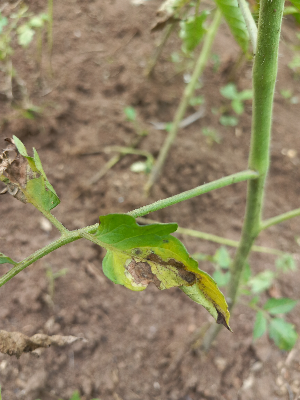

In [4]:
# Print out test image
test_img = '/content/crop-disease-ghana/input/Tomato/Tomato__Early_Blight/images/20230518_134246.jpg'
test_img = cv2.imread(test_img)
#cv2_imshow(test_img)

def display_image(test_img):
    h, w = test_img.shape[0:2]
    neww = 300
    newh = int(neww*(h/w))
    test_img = cv2.resize(test_img, (neww, newh))
    cv2_imshow(test_img)
    cv2.waitKey(0)

display_image(test_img)

In [5]:
# Show files in directory
os.listdir('/content/crop-disease-ghana/input')

['label_map.pbtxt',
 'Corn',
 'label_map.json',
 'dataset_labels.csv',
 'catyegory_index.pbtxt',
 'label_map.txt',
 'Tomato',
 'Pepper']

In [6]:
# Read csv file with data labels
labels_df = pd.read_csv('/content/crop-disease-ghana/input/dataset_labels.csv')
labels_df.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path
0,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2052.653343,695.836619,2210.117161,785.809054,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
1,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1110.682288,901.086237,1228.780152,982.623756,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
2,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1647.746382,912.332791,1791.150930,1002.305226,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
3,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2491.302550,1275.034169,2589.717436,1367.818243,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
4,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,3326.423156,1255.352699,3410.778773,1339.701857,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...


In [7]:
# Create new column combining width and height column
labels_df['shape'] = 0
shape_lst = []
for i in range(len(labels_df)):
  shape_lst.append((labels_df['width'][i],labels_df['height'][i]))

labels_df['shape'] = shape_lst
labels_df['shape'].value_counts()

(4032, 3024)    19548
(4080, 1836)    13500
(1920, 1280)    12418
(4080, 3060)     9007
(720, 480)       1473
(4000, 3000)     1123
(6720, 4480)      552
(1920, 2560)      428
(2560, 1920)      210
(2576, 1932)      102
Name: shape, dtype: int64

In [8]:
# Labels for categories
f = open('/content/crop-disease-ghana/input/label_map.json')
label_json = json.load(f)
label_json

{'Corn Cercospora Leaf Spot': 1,
 'Corn Common Rust': 2,
 'Corn Healthy': 3,
 'Corn Streak': 4,
 'Corn Northern Leaf Blight': 5,
 'Pepper Leaf Curl': 6,
 'Pepper Cercospora': 7,
 'Pepper Leaf Blight': 8,
 'Pepper Bacterial Spot': 9,
 'Pepper Leaf Mosaic': 10,
 'Pepper Healthy': 11,
 'Pepper Fusarium': 12,
 'Pepper Septoria': 13,
 'Pepper Late Blight': 14,
 'Pepper Early Blight': 15,
 'Tomato Late Blight': 16,
 'Tomato Early Blight': 17,
 'Tomato Bacterial Spot': 18,
 'Tomato Septoria': 19,
 'Tomato Fusarium': 20,
 'Tomato Leaf Curl': 21,
 'Tomato Healthy': 22,
 'Tomato Mosaic': 23}

<Axes: xlabel='crop', ylabel='count'>

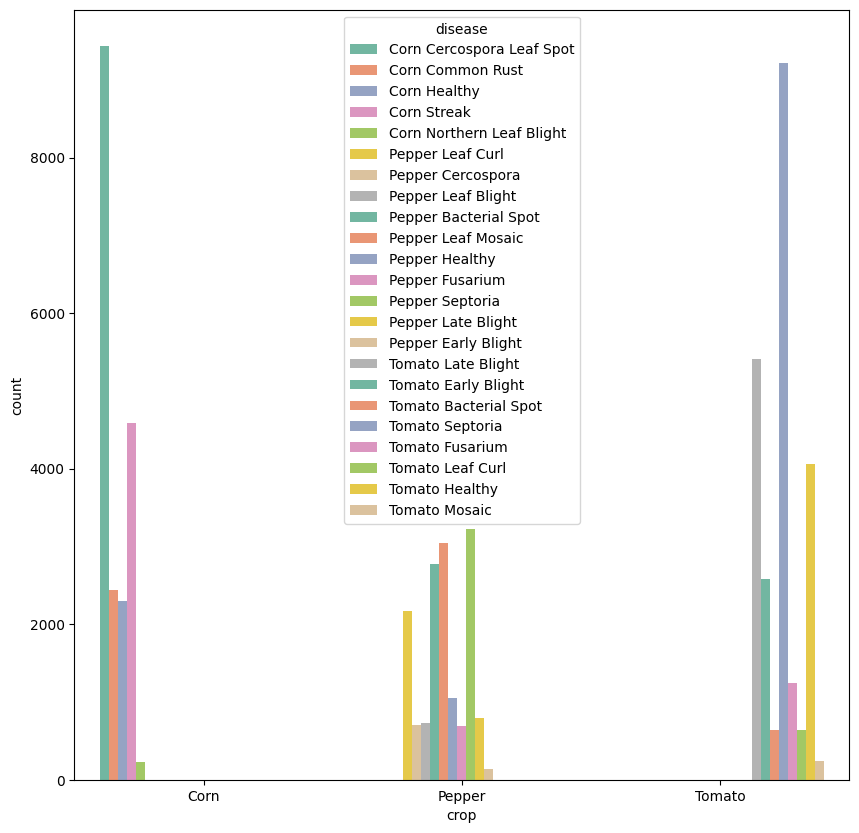

In [10]:
# Crop type and disease distribution
plt.figure(figsize = (10,10))
sns.countplot(x = labels_df['crop'],hue = labels_df['disease'],palette = 'Set2')

In [11]:
# Disease value counts
labels_df['disease'].value_counts()

Corn Cercospora Leaf Spot    9431
Tomato Septoria              9211
Tomato Late Blight           5408
Corn Streak                  4591
Tomato Healthy               4066
Pepper Septoria              3222
Pepper Leaf Mosaic           3047
Pepper Bacterial Spot        2780
Tomato Early Blight          2585
Corn Common Rust             2434
Corn Healthy                 2304
Pepper Leaf Curl             2175
Tomato Fusarium              1238
Pepper Healthy               1049
Pepper Late Blight            792
Pepper Leaf Blight            730
Pepper Cercospora             704
Pepper Fusarium               696
Tomato Leaf Curl              641
Tomato Bacterial Spot         639
Tomato Mosaic                 246
Corn Northern Leaf Blight     234
Pepper Early Blight           138
Name: disease, dtype: int64

### Looks like there is class imbalance. In order to address this problem, there should be a combination of resampling and data augmentation.

In [12]:
# Create balanced dataset

df_balanced = pd.DataFrame(columns = labels_df.columns)
for i in np.unique(labels_df['disease']):
  df = labels_df[labels_df['disease']==i]
  samp = df.sample(n = 138)
  df_balanced = df_balanced.append(samp,ignore_index = True)

<ipython-input-12-d9dc1177704d>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_balanced = df_balanced.append(samp,ignore_index = True)


In [13]:
df_balanced

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape
0,20230525_112307.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1676.477987,210.924398,2158.322851,735.495827,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...,"(4080, 1836)"
1,20230525_111603(1).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1813.645762,583.371076,1928.931771,676.155149,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...,"(4080, 1836)"
2,20230525_111551(0).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1313.135768,923.579345,1481.847002,1050.103082,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...,"(4080, 1836)"
3,20230525_085639(0).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,3926.661754,463.742124,4004.834193,541.869783,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...,"(4080, 1836)"
4,20230525_111516.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2007.663680,1055.726359,2092.019297,1137.263878,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...,"(4080, 1836)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,2N8A1369.JPG,Tomato Septoria,Tomato,1920,1280,3,877.663934,878.501171,921.135831,971.270492,input\Tomato\Tomato__Late_Blight\annotations\2...,input\Tomato\Tomato__Late_Blight\images\2N8A13...,"(1920, 1280)"
3170,IMG_6287.jpeg,Tomato Septoria,Tomato,4032,3024,3,671.487228,2727.681425,824.313110,2859.406187,input\Tomato\Tomato__Septoria\annotations\IMG_...,input\Tomato\Tomato__Septoria\images\IMG_6287....,"(4032, 3024)"
3171,IMG_6286.jpeg,Tomato Septoria,Tomato,4032,3024,3,3351.602367,1706.764216,3555.322878,1887.881325,input\Tomato\Tomato__Septoria\annotations\IMG_...,input\Tomato\Tomato__Septoria\images\IMG_6286....,"(4032, 3024)"
3172,IMG_6188.jpeg,Tomato Septoria,Tomato,4032,3024,3,1646.877524,1082.531250,1839.279192,1190.752561,input\Tomato\Tomato__Late_Blight\annotations\I...,input\Tomato\Tomato__Late_Blight\images\IMG_61...,"(4032, 3024)"


In [14]:
# Fix img path
loc_path = '/content/crop-disease-ghana/'
new_img = []
for txt in df_balanced['img_path']:
  n = loc_path + txt.replace('\\','/')
  new_img.append(n)
df_balanced['img_path'] = new_img
df_balanced['img_path'][0]

'/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/images/20230525_112307.jpg'

In [15]:
# Fix annotation path
loc_path = '/content/crop-disease-ghana/'
new_ann = []
for txt in df_balanced['ann_path']:
  a = loc_path + txt.replace('\\','/')
  new_ann.append(a)
df_balanced['ann_path'] = new_ann
df_balanced['ann_path'][0]

'/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/annotations/20230525_112307.xml'

In [16]:
df_balanced['disease'].value_counts()

Corn Cercospora Leaf Spot    138
Pepper Leaf Curl             138
Tomato Mosaic                138
Tomato Leaf Curl             138
Tomato Late Blight           138
Tomato Healthy               138
Tomato Fusarium              138
Tomato Early Blight          138
Tomato Bacterial Spot        138
Pepper Septoria              138
Pepper Leaf Mosaic           138
Pepper Leaf Blight           138
Corn Common Rust             138
Pepper Late Blight           138
Pepper Healthy               138
Pepper Fusarium              138
Pepper Early Blight          138
Pepper Cercospora            138
Pepper Bacterial Spot        138
Corn Streak                  138
Corn Northern Leaf Blight    138
Corn Healthy                 138
Tomato Septoria              138
Name: disease, dtype: int64

In [17]:
# Define padding function
# Use this tutorial as a guide:
# https://note.nkmk.me/en/python-pillow-add-margin-expand-canvas/
def pad_img(im,top, right, bottom =0, left = 0, color = (0,0,0)):

    photo = Image.open(im)
    size = photo.size
    new_width = size[0] + right + left
    new_height = size[1] + top + bottom
    result = Image.new(photo.mode, (new_width, new_height), color)
    result.paste(photo, (left, top))
    return result
# Test out function
pad_img(df_balanced['img_path'][0],500,350)
#display_image(test_img)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
width=256
height=256
depth= epoch_= 25
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
#root_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'
INIT_LR = 1e-3


In [19]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [20]:
image_list, label_list = [], []
indx=0
try:
  for img_dir in df_balanced['img_path']:
    #img_dir= f"{root_dir}/{plant_folder}/{plant_disease_folder}/{image}"
    if img_dir.endswith(".jpg") == True or img_dir.endswith(".JPG") == True:
        image_list.append(convert_image_to_array(img_dir))
        label_list.append(df_balanced['disease'][indx])
        indx=indx+1
except Exception as e:
  print(f"Error : {e}")

In [21]:
print(len(image_list))
print(len(label_list))

2079
2079


In [22]:
label_binarizer = LabelBinarizer()
if label_list is not None:
  image_labels = label_binarizer.fit_transform(label_list)
  pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
  n_classes = len(label_binarizer.classes_)

In [23]:
print(label_binarizer.classes_)

['Corn Cercospora Leaf Spot' 'Corn Common Rust' 'Corn Healthy'
 'Corn Northern Leaf Blight' 'Corn Streak' 'Pepper Bacterial Spot'
 'Pepper Cercospora' 'Pepper Early Blight' 'Pepper Fusarium'
 'Pepper Healthy' 'Pepper Late Blight' 'Pepper Leaf Blight'
 'Pepper Leaf Curl' 'Pepper Leaf Mosaic' 'Pepper Septoria'
 'Tomato Bacterial Spot']


In [24]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [25]:
train_x, test_x, train_y, test_y = train_test_split(np_image_list, image_labels, test_size=0.5, random_state = 75)

In [26]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [27]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [28]:
model = Sequential()
inputShape = (height, width, 3)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (3, height, width)
    chanDim = 1

In [29]:
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [30]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / epoch_)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [31]:
history = model.fit_generator(
    aug.flow(train_x, train_y, batch_size=BS),
    validation_data=(test_x, test_y),
    steps_per_epoch=len(train_x) // BS,
    #epochs=epoch_, verbose=1
    epochs=25, verbose=1
    )

<ipython-input-31-c99c039c5a95>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
32/32 [==============================] - 38s 736ms/step - loss: 0.7831 - accuracy: 0.1182 - val_loss: 0.7260 - val_accuracy: 0.0615
Epoch 2/25
32/32 [==============================] - 19s 581ms/step - loss: 0.5035 - accuracy: 0.1231 - val_loss: 0.5449 - val_accuracy: 0.0692
Epoch 3/25
32/32 [==============================] - 19s 589ms/step - loss: 0.2827 - accuracy: 0.1797 - val_loss: 0.3398 - val_accuracy: 0.0635
Epoch 4/25
32/32 [==============================] - 18s 577ms/step - loss: 0.2312 - accuracy: 0.2214 - val_loss: 1.1359 - val_accuracy: 0.0894
Epoch 5/25
32/32 [==============================] - 20s 623ms/step - loss: 0.2139 - accuracy: 0.2830 - val_loss: 0.6483 - val_accuracy: 0.0885
Epoch 6/25
32/32 [==============================] - 19s 582ms/step - loss: 0.2115 - accuracy: 0.2661 - val_loss: 0.5078 - val_accuracy: 0.0663
Epoch 7/25
32/32 [==============================] - 19s 592ms/step - loss: 0.2043 - accuracy: 0.2820 - val_loss: 0.3177 - val_accuracy: 0.1288

In [32]:
# Draw Learning curve
def learning_curve(hist):
  #Create a function to draw learning curves
  # This will help you to just call this function in future for drawing the learning curves
  plt.subplot(2,1,1)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='lower right')

  plt.subplot(2,1,2)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.show()

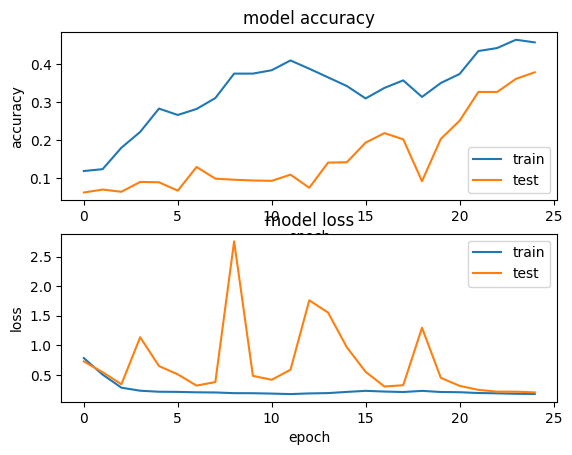

In [33]:
learning_curve(history)

In [34]:
img = '/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/images/20230524_105910.jpg'

In [35]:
im = convert_image_to_array(img)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [36]:
result = model.predict(npp_image)
print(result)
itemindex = np.where(result == np.max(result))
print("Probability: " + str(np.max(result)) + "\n" + label_binarizer.classes_[itemindex[1][0]])

1/1 [==============================] - 1s 501ms/step
[[9.59871054e-01 2.72345953e-02 6.63384679e-04 6.81223255e-03
  1.07000652e-03 4.84990014e-04 1.49964399e-04 1.01150792e-04
  1.66806218e-04 5.92990080e-04 7.60894909e-04 4.71044274e-04
  1.68292710e-04 1.32906716e-03 1.10744404e-04 1.27954481e-05]]
Probability: 0.95987105
Corn Cercospora Leaf Spot


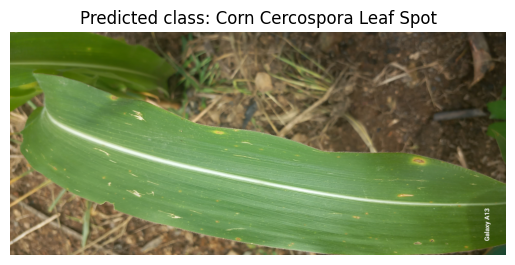

In [37]:
image = Image.open(img)
plt.imshow(image)
plt.axis('off')
plt.title("Predicted class: " + label_binarizer.classes_[itemindex[1][0]])
plt.show()

In [38]:
scores = model.evaluate(test_x, test_y)
print(f"Test Accuracy: {scores[1]*100}")

33/33 [==============================] - 1s 36ms/step - loss: 0.2026 - accuracy: 0.3788
Test Accuracy: 37.88461685180664
